In [3]:
import statsmodels.api as sm
from scipy.stats import permutation_test, ttest_1samp, bootstrap
from statsmodels.regression.linear_model import OLS
import pandas as pd
import numpy as np
df = pd.read_excel('../data/processed/df_metanalysis.xlsx')

paper_id_to_citation = {
    20: "Wiem & Lachiri, 2017",
    23: "Ayata et al., 2017",
    32: "Siddharth et al., 2018",
    38: "Ayata et al., 2017",
    63: "Sharma et al., 2019",
    66: "Ganapathy et al., 2020",
    74: "Chang et al., 2019",
    82: "Santamaria-Granados et al., 2018",
    86: "Ganapathy & Swaminathan, 2020",
    91: "Susanto et al., 2020",
    94: "Yin et al., 2019",
    97: "Ganapathy & Swaminathan, 2019",
    109: "Bota et al., 2023",
    113: "Selvi & Vijayakumaran, 2023",
    116: "Jung & Sejnowski, 2019",
    117: "Saffaryazdi et al., 2024",
    #129: "Ganapathy et al., 2021",
    131: "Pidgeon et al., 2022",
    133: "Dessai & Virani, 2023",
    135: "Gahlan & Sethia, 2024",
    138: "Chen et al., 2022",
    139: "Mu et al., 2024",
    142: "Perry Fordson et al., 2022",
    145: "Zhu et al., 2023",
    150: "Yin et al., 2022",
    154: "Joo et al., 2024",
    156: "Raheel et al., 2021",
    157: "Veeranki et al., 2024",
    161: "Shukla et al., 2019",
    162: "Chatterjee et al., 2022",
    163: "Tabbaa et al., 2021",
    166: "Gohumpu et al., 2023",
    171: "Singh et al., 2023",
    173: "Kumar & Fredo, 2025",
    174: "Liu et al., 2023",
    182: "Elalamy et al., 2021"
}
df

,paper_id,model_id,apa_citation,year,database,ML_model,N,output_arousal,accuracy_arousal,output_valence,accuracy_valence,model_family
0,20,130-1,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...",2016,MAHNOB,class_Support Vector Machine (SVM) Lineal,24,"HA, LA",55.94,"HV, LV",54.73,Support Vector Machine
1,20,130-2,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...",2016,MAHNOB,class_Support Vector Machine (SVM) Polynomial,24,"HA, LA",53.14,"HV, LV",55.78,Support Vector Machine
2,20,130-3,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...",2016,MAHNOB,class_Support Vector Machine (SVM) Gaussian,24,"HA, LA",62.23,"HV, LV",50.52,Support Vector Machine
3,23,147-1,"Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...",2016,DEAP,class_Tree based models 10x63 No -Conv,32,"HA, LA",70.78,"HV, LV",69.60,Tree-based Models
4,23,147-2,"Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...",2016,DEAP,class_Tree based models 10x21 No -Conv,32,"HA, LA",71.53,"HV, LV",70.54,Tree-based Models
...,...,...,...,...,...,...,...,...,...,...,...,...
149,174,76,"Liu, Y., Jia, Z., & Wang, H. (2023, October). ...",2023,MAHNOB,Transformer,32,HA; LA,56.86,HV; LV,59.56,Other / Unclear
150,182,77,"Elalamy, R., Fanourakis, M., & Chanel, G. (202...",2021,AMIGOS,logistic_regression,32,HA; LA,70.00,HV; LV,71.10,Linear Models
151,182,78,"Elalamy, R., Fanourakis, M., & Chanel, G. (202...",2021,AMIGOS,logistic_regression,32,HA; LA,79.10,HV; LV,78.20,Linear Models
152,182,79,"Elalamy, R., Fanourakis, M., & Chanel, G. (202...",2021,DEAP,logistic_regression,32,HA; LA,64.60,HV; LV,65.30,Linear Models


In [5]:
df['diff_acc'] = df['accuracy_arousal'] - df['accuracy_valence']

df['mean_acc'] = np.mean([df['accuracy_arousal'], df['accuracy_valence']], axis=0)

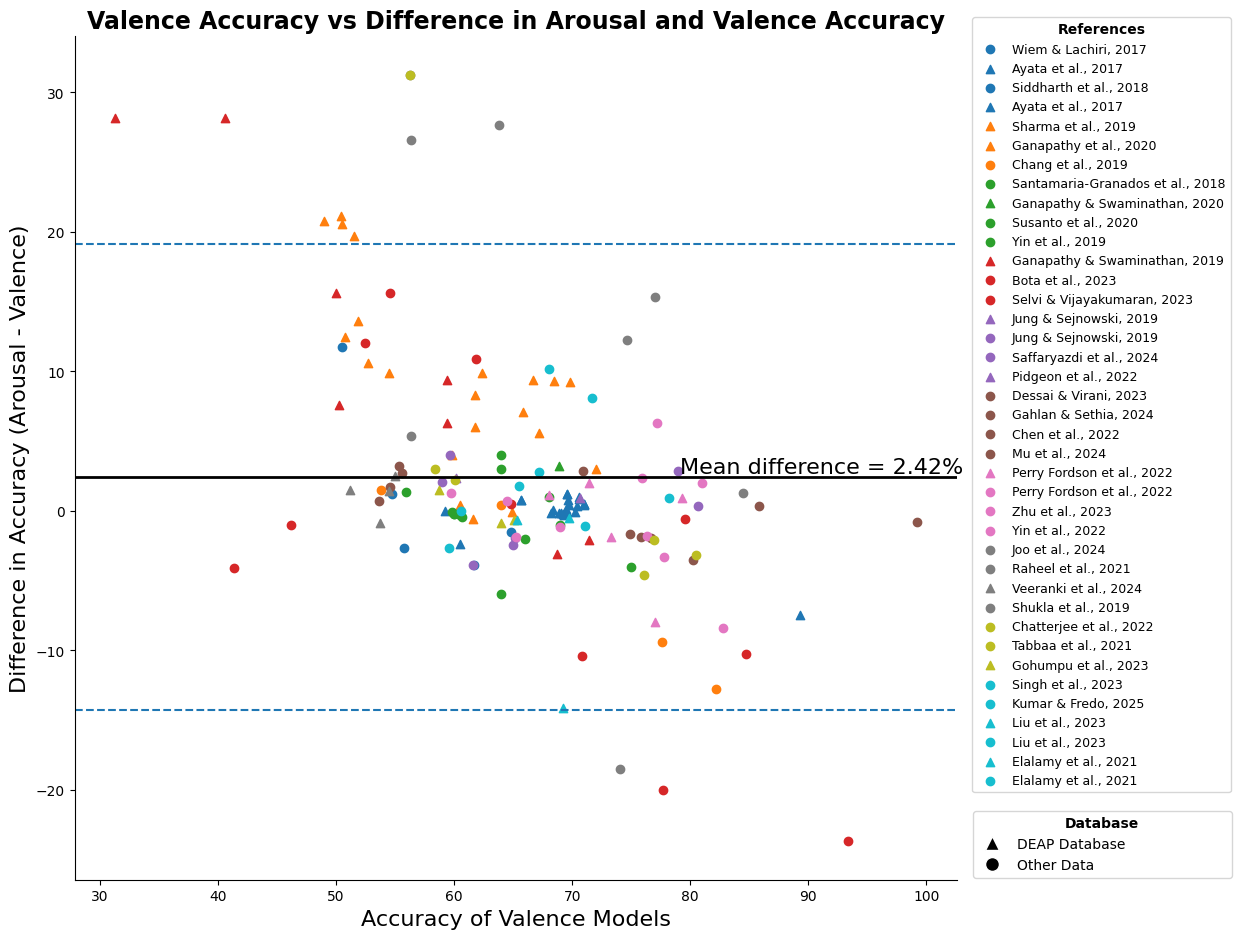

In [13]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Unique paper IDs
unique_paper_ids = df['paper_id'].unique()

# Create a color map for paper IDs
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_paper_ids)))

plt.figure(figsize=(22, 9.5))  # Significantly increased width to accommodate the legend

# Calculate the mean difference in accuracy
mean_diff_acc = np.mean(df['diff_acc'])

# Add a horizontal line to represent the mean difference in accuracy
plt.axhline(mean_diff_acc, color='black', linestyle='-', linewidth=2)

# Add text to indicate the mean value
plt.text(max(df['accuracy_valence']) * 1.04, mean_diff_acc, f'Mean difference = {mean_diff_acc:.2f}%', verticalalignment='bottom', horizontalalignment='right', fontsize=16)

# Calculate the correlation coefficient and p-value
slope, intercept, r_value, p_value, std_err = linregress(df['accuracy_valence'], df['diff_acc'])

for i, paper_id in enumerate(unique_paper_ids):
    subset = df[df['paper_id'] == paper_id]
    
    # Check if database is DEAP for the subset
    is_DEAP = subset['database'] == 'DEAP'
    
    # Get the citation for the paper ID
    citation = paper_id_to_citation.get(paper_id, f"Paper ID {paper_id}")
    
    # Plot points with database == DEAP using triangles
    if any(is_DEAP):
        plt.scatter(subset['accuracy_valence'][is_DEAP], subset['diff_acc'][is_DEAP], 
                    color=colors[i], marker='^', label=f"{citation}")
    
    # Plot other points using circles
    if any(~is_DEAP):
        plt.scatter(subset['accuracy_valence'][~is_DEAP], subset['diff_acc'][~is_DEAP], 
                    color=colors[i], label=citation)

# Adding horizontal lines
plt.axhline(np.mean(df['diff_acc']) + 1.96 * np.std(df['diff_acc']), linestyle='--')
plt.axhline(np.mean(df['diff_acc']) - 1.96 * np.std(df['diff_acc']), linestyle='--')

# Adding labels and title
plt.xlabel('Accuracy of Valence Models', fontsize=16)
plt.ylabel('Difference in Accuracy (Arousal - Valence)', fontsize=16)
plt.title('Valence Accuracy vs Difference in Arousal and Valence Accuracy', fontsize=17, fontweight='bold')

# Adjust the layout to maintain the plot size
plt.tight_layout(rect=[0, 0, 0.45, 1])  # Adjusted to leave about 1/3 of figure width for legends

# Get handles and labels for the references
handles, labels = plt.gca().get_legend_handles_labels()

# Single legend for all references with increased font size for better readability
legend1 = plt.legend(handles, labels, title='References', 
                    bbox_to_anchor=(1.01, 1.03), loc='upper left', ncol=1, 
                    fontsize=9, title_fontsize=10)
plt.gca().add_artist(legend1)
plt.setp(legend1.get_title(), weight='bold')

# Legend for marker types
legend3 = plt.legend([plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='black', markersize=10),
                      plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10)],
                     ['DEAP Database                       ', 'Other Data'], 
                     title='Database', 
                     bbox_to_anchor=(1.01, 0.09), loc='upper left')
plt.setp(legend3.get_title(), weight='bold')

# Remove spines
sns.despine()

# Show the plot
plt.show()

In [14]:
x = df['diff_acc']

In [15]:
x

0       1.21
1      -2.64
2      11.71
3       1.18
4       0.99
       ...  
149    -2.70
150    -1.10
151     0.90
152    -0.70
153    -0.50
Name: diff_acc, Length: 154, dtype: float64

In [16]:
np.mean(x)

np.float64(2.415389610389611)

In [17]:
def my_stat(x):
    return ttest_1samp(x, popmean=0).statistic

In [18]:
permutation_test((x.values,), my_stat, permutation_type='samples')

PermutationTestResult(statistic=np.float64(3.50632042468644), pvalue=np.float64(0.001), null_distribution=array([ 1.72311432e-03,  3.34315526e-01, -9.53343274e-01, ...,
       -6.49419025e-01, -2.03005648e+00,  5.94616154e-01], shape=(9999,)))

In [20]:
bootstrap((x.values,), my_stat)

BootstrapResult(confidence_interval=ConfidenceInterval(low=np.float64(1.5891180446796611), high=np.float64(5.214953997986853)), bootstrap_distribution=array([2.996508  , 3.65783206, 2.1704088 , ..., 3.10570571, 3.47504072,
       3.74036281], shape=(9999,)), standard_error=np.float64(0.9192434581324702))

# Interpretation of the permutation test and bootstrap results
 
The permutation test evaluates whether the difference between arousal and valence accuracy (diff_acc) is significantly different from zero:
Test statistic: 3.51 (t-value from one-sample t-test)
P-value: 0.001 
Null distribution: Generated through 9999 random permutations

The bootstrap analysis provides additional confidence in our findings:
95% Confidence Interval: [1.59, 5.21]
Standard Error: 0.92
Bootstrap Distribution: Generated from 9999 resamples

Both analyses confirm a statistically significant difference between arousal and valence accuracy. Since the confidence interval does not include zero and the mean difference is 2.42, we can conclude with high confidence that arousal accuracy is significantly higher than valence accuracy in the analyzed models.

In [44]:
X = df[['N', 'year', 'mean_acc']]
X = sm.add_constant(X)


In [45]:
y = df['diff_acc']

In [46]:
model = OLS(y, X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               diff_acc   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.026
Date:                Fri, 09 May 2025   Prob (F-statistic):              0.113
Time:                        14:54:34   Log-Likelihood:                -545.40
No. Observations:                 154   AIC:                             1099.
Df Residuals:                     150   BIC:                             1111.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -376.4580    537.470     -0.700      0.485   -1438.448     685.531
N             -0.0104      0.008     -1.237      0.218      -0.027       0.006
year           0.1936      0.266      0.727      0.468      -0.332       0.720
mean_acc      -0.1753      0.079     -2.220      0.028      -0.331      -0.019
==============================================================================
Omnibus:                       31.883   Durbin-Watson:                   1.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.392
Skew:                           0.880   Prob(JB):                     3.14e-16
Kurtosis:                       5.834   Cond. No.                     1.59e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The result shows that mean accuracy (mean_acc) has a significant negative effect (p=0.028) on the difference in accuracy between arousal and valence.

In [51]:
# This code performs a robust linear regression (RLM) analysis which is less sensitive to outliers
# than traditional OLS regression. It uses Huber's norm (HuberT) to reduce the influence of outliers.
# It examines how the independent variables (N, year, mean_acc) affect the difference in accuracy between
# arousal and valence (diff_acc), providing more robust estimates when there are extreme data points.
rlm_mod = sm.RLM(y, X, M=sm.robust.norms.HuberT())
rlm_res = rlm_mod.fit()
rlm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               diff_acc   No. Observations:                  154
Model:                            RLM   Df Residuals:                      150
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 09 May 2025                                         
Time:                        14:58:55                                         
No. Iterations:                    21                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -92.4694    307.050     -0.301      0.763    -694.276     509.337
N             -0.0056      0.005     -1.173      0.241      -0.015       0.004
year           0.0498      0.152      0.328      0.743      -0.248       0.348
mean_acc      -0.0993      0.045     -2.202      0.028      -0.188      -0.011
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

# Interpretation of the robust regression results:
The robust regression confirms the findings from the OLS model but with more reliable estimates
in the presence of outliers. The mean accuracy (mean_acc) remains a significant predictor (p=0.028)
with a negative coefficient (-0.0993), indicating that as overall accuracy increases, the difference
between arousal and valence accuracy decreases. Neither sample size (N) nor publication year (year)
significantly affects the difference in accuracy. The model is less influenced by extreme values
compared to the standard OLS regression, providing more stable coefficient estimates.